## Preparation

### Preparation > Imports

In [2]:
''' IMPORTS '''
import numpy as np
import pandas as pd
import matplotlib as plot
import math 
import string

from enum import Enum    

# for plotting
import matplotlib.pyplot as plt
import scipy.stats as stats

from matplotlib import cm
from scipy.stats import multivariate_normal

### Preparation > Classes

In [3]:
'''CLASSES '''
class Cols(Enum):
        StatusOfExistingCheckingAccount = 0,
        DurationInMonth = 1, 
        CreditHistory = 2, 
        Purpose = 3, 
        CreditAmount = 4 , 
        SavingsAccountBonds =5,
        PresentEmploymentSince =6 ,
        InstallmentRateInPercentageOfDisposableIncome =7 ,
        PersonalStatusAndSex = 8,
        OtherDebtorsOrGuarantors =9 ,
        PresentResidenceSince =10 ,
        Property =11 ,
        AgeInYears = 12,
        OtherInstallmentPlans =13 ,
        Housing = 14,
        NumberOfExistingCreditsAtThisBank =15 ,
        Job = 16,
        NumberOfPeopleBeingLiableToProvideMaintenanceFor =17 ,
        Telephone = 18,
        ForeignWorker =19 ,
        ClassOutcome = 20
        
class Outcomes(Enum):
        Good = 1
        Bad = 2

### Preparation > Constances

In [4]:
'''CONSTANCES'''
# dict of all column names
COLS = {
        Cols.StatusOfExistingCheckingAccount : "Status of existing checking account" ,
        Cols.DurationInMonth:"Duration in month" , # numerical
        Cols.CreditHistory: "Credit history", 
        Cols.Purpose:"Purpose" , 
        Cols.CreditAmount:  "Credit amount",  # numerical
        
        Cols.SavingsAccountBonds: "Savings account/bonds" ,
        Cols.PresentEmploymentSince:"Present employment since" ,
        Cols.InstallmentRateInPercentageOfDisposableIncome: "Installment rate in percentage of disposable income", # numerical
        Cols.PersonalStatusAndSex: "Personal status and sex",
        Cols.OtherDebtorsOrGuarantors:"Other debtors / guarantors", 
        
        Cols.PresentResidenceSince: "Present residence since", # numerical
        Cols.Property: "Property", 
        Cols.AgeInYears: "Age in years", # numerical
        Cols.OtherInstallmentPlans:"Other installment plans", 
        Cols.Housing: "Housing", 
        
        Cols.NumberOfExistingCreditsAtThisBank:"Number of existing credits at this bank", # numerical
        Cols.Job: "Job",
        Cols.NumberOfPeopleBeingLiableToProvideMaintenanceFor:"Number of people being liable to provide maintenance for", 
        Cols.Telephone: "Telephone",
        Cols.ForeignWorker:"Foreign worker",
        
            Cols.ClassOutcome: "Class/Outcome"
}

# model parameter
PERC_TRAIN = 0.67
PERC_TEST = 1-PERC_TRAIN

# constants
PI = np.pi
numerical_attr = [
    COLS[Cols.DurationInMonth],
    COLS[Cols.CreditAmount],
    COLS[Cols.PresentResidenceSince],
    COLS[Cols.InstallmentRateInPercentageOfDisposableIncome], 
    COLS[Cols.AgeInYears], 
    COLS[Cols.NumberOfExistingCreditsAtThisBank],
]

### Model > Load Data

In [5]:
df_normal = pd.read_csv(
    "german.data", 
    sep=" ",
    names=[
        COLS[Cols.StatusOfExistingCheckingAccount],
        COLS[Cols.DurationInMonth],
        COLS[Cols.CreditHistory],
        COLS[Cols.Purpose],
        COLS[Cols.CreditAmount],
        COLS[Cols.SavingsAccountBonds],
        COLS[Cols.PresentEmploymentSince],
        COLS[Cols.InstallmentRateInPercentageOfDisposableIncome],
        COLS[Cols.PersonalStatusAndSex],
        COLS[Cols.OtherDebtorsOrGuarantors],
        COLS[Cols.PresentResidenceSince],
        COLS[Cols.Property],
        COLS[Cols.AgeInYears],
        COLS[Cols.OtherInstallmentPlans],
        COLS[Cols.Housing],
        COLS[Cols.NumberOfExistingCreditsAtThisBank],
        COLS[Cols.Job],
        COLS[Cols.NumberOfPeopleBeingLiableToProvideMaintenanceFor],
        COLS[Cols.Telephone],
        COLS[Cols.ForeignWorker],
        COLS[Cols.ClassOutcome],
    ])


df_numerical = pd.read_csv(
    "german.data-numeric", 
    delim_whitespace=True,
    header=None,
    names = [
        'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
           COLS[Cols.ClassOutcome]]
)

df_numerical.head(3)

,a,b,c,d,e,f,g,h,i,j,...,p,q,r,s,t,u,v,w,x,Class/Outcome
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1


## Model

### Model > Functions > Classification

In [6]:
'''FUNCTIONS'''
    
# to calculate un-normalized posteriors and do classification with respect to g1 and g2results
def do_classification(df_test, cols,
                      prior_good, muv_good, covma_good,
                      prior_bad, muv_bad, covma_bad):
    decision_list = []  # to store classification results to calculate accuracy later.
    
    # classify all test rows
    for index, row in df_test.iterrows():
        pred_good = discriminant_func(x=row, cols=cols, prior=prior_good, mus=muv_good, covma=covma_good)
        pred_bad = discriminant_func(x=row, cols=cols, prior=prior_bad, mus=muv_bad, covma=covma_bad)
        
        # take higher posterior (-> higher probabilty)
        classified_class = Outcomes.Good.value if pred_good>pred_bad else Outcomes.Bad.value
        decision_list.append(classified_class)
        
    return decision_list


def discriminant_func(x, cols, prior, mus, covma):
    cov01 = covma[0,1]
    standard_dev = math.sqrt(abs(cov01))
    
    if standard_dev == 0:
        return -900000000000
    
    res =  (
            -(math.log(2*PI)/2) 
            - math.log(standard_dev) 
            - ((x[cols[0]]-mus[0])**2)/(2*cov01) 
            + np.log(prior)
        )+ (
            -(math.log(2*PI)/2) 
            - math.log(standard_dev) 
            - ((x[cols[1]]-mus[1])**2)/(2*cov01) 
            + np.log(prior)
    )
    return res
    

# to find maximum of the discriminant function results
def find_max_likelihood(g1, g2):
    likelihood_list = [g1, g2]
    return max(likelihood_list)

### Model > Functions > Plot

In [7]:
def plot_contour(mu, covma, scale, top_attr):
    '''
    plots a contour plot for given gaussian attributes (mu, covmatrix)
    '''
    sigma = covma[0,1]
    
    x = np.linspace(0, mu[0]*scale, num=100)
    y = np.linspace(0, mu[1]*scale, num=100)
    X, Y = np.meshgrid(x,y)

    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    F = multivariate_normal(mu, covma)
    Z = F.pdf(pos)
    plt.xlabel(f"{top_attr[0]}")
    plt.ylabel(f"{top_attr[1]}")
    
    plt.title(f'''$\mu$ ({top_attr[0]}) = {mu[0]}
                  $\mu$ ({top_attr[1]}) = {mu[1]}
                  $\Sigma$ = {covma}''')
    plt.contourf(X, Y, Z, cmap=cm.Greys)
    plt.colorbar()
    
def plot_sample(df, top_attr, plot_scale):
    '''
    - seperates {df} in class good & bad 
    - calculates gaussian variables (mu & covmatrix) for each class
    - plots 2d gaussiann for each class
    '''
    # plot distribution for best attributes
    df_plot = pd.DataFrame({
        top_attr[0]: df[top_attr[0]],
        top_attr[1]: df[top_attr[1]],
        COLS[Cols.ClassOutcome]: df[COLS[Cols.ClassOutcome]]
    })

    # class GOOD - mu & covma
    df_plot_good = df_plot.loc[df_plot[COLS[Cols.ClassOutcome]] == Outcomes.Good.value]
    df_plot_good_cov = pd.DataFrame({
        top_attr[0]: df_plot_good[top_attr[0]],
        top_attr[1]: df_plot_good[top_attr[1]]
    })
    mu_good = [df_plot_good[top_attr[0]].mean(), df_plot_good[top_attr[1]].mean()]
    mu_good = list(map(lambda x: round(x, 2), mu_good))
    
    
    covma_good = df_plot_good_cov.cov().to_numpy()
    
    # class BAD - mu & covma
    df_plot_bad  = df_plot.loc[df_plot[COLS[Cols.ClassOutcome]] == Outcomes.Bad.value]
    df_plot_bad_cov = pd.DataFrame({
        top_attr[0]: df_plot_bad[top_attr[0]],
        top_attr[1]: df_plot_bad[top_attr[1]],
    })
    mu_bad =  [df_plot_bad [top_attr[0]].mean(), df_plot_bad [top_attr[1]].mean()]
    mu_bad = list(map(lambda x: round(x, 2), mu_bad))

    cov_bad = df_plot_bad_cov.cov().to_numpy()
    
    # plot good & bad
    print(f'covma={covma_good}')
    plot_contour(
        mu=mu_good, covma=covma_good,
        scale=plot_scale, top_attr=top_attr
    )

## Model > Training (run  500x)

### Gradient Descent

In [8]:
def routine_gradient_descent(df, columns, iterations, plot_scale):
    max_avg_acc = 0
    top_attr = []
    
    # iterate through all possible attributes to determine highest accuracy
    for i, attr1 in enumerate(columns):
        for attr2 in columns:
            if attr1 == attr2:
                continue

                
            
            df_focus = pd.DataFrame({
                        attr1 : df[attr1],
                        attr2 : df[attr2],
                        COLS[Cols.ClassOutcome] : df[COLS[Cols.ClassOutcome]]
            })
            max_avg,mu,covma = gradient_descent(df_focus, iterations)

            if max_avg > max_avg_acc:
                max_avg_acc = max_avg
                top_attr = [attr1,attr2]
        print(f"=============Progress: {round((i+1)/len(columns),2)}==============")


    print(f'Best Avg. Acc: {max_avg_acc} with features: <{top_attr[0]}> & <{top_attr[1]}>')
    
    # plot distribution 
    plot_sample(df, top_attr, plot_scale)
    

def gradient_descent(df, iterations):
    accuracy = 0  # total accuracy
    accuracies=[] # to store individual accuracies
    cols = df.columns

    # program will run for 500 times to find average accuracy
    for i in range(0, iterations):    
        # split data train & test
        msk = np.random.rand(len(df)) < PERC_TRAIN
        df_train = df[msk]
        df_test = df[~msk]
        
        # separate in class 1 & 2
        df_good = df_train.loc[df_train[COLS[Cols.ClassOutcome]] == 1]    
        df_bad  = df_train.loc[df_train[COLS[Cols.ClassOutcome]] == 2]

        prior_good = len(df_good)/(len(df_good)+len(df_bad)) 
        prior_bad = len(df_bad)/(len(df_good)+len(df_bad)) 

        # calculate MUs and COVs(MLE parameters) of each class
        df_good_covma = pd.DataFrame({
            cols[0]: df_good[cols[0]],
            cols[1]: df_good[cols[1]],
        })
        muv_good = [df_good[cols[0]].mean(), df_good[cols[1]].mean()]
        covma_good = df_good_covma.cov().to_numpy()

        df_bad_covma = pd.DataFrame({
            cols[0]: df_bad[cols[0]],
            cols[1]: df_bad[cols[1]],
        })
        muv_bad = [df_bad[cols[0]].mean(), df_bad[cols[1]].mean()]
        covma_bad = df_bad_covma.cov().to_numpy()

        # classification_result is an array that stores the result of classification
        classification_result = do_classification(
            df_test=df_test, cols=cols,
            prior_good=prior_good, muv_good=muv_good, covma_good=covma_good, 
            prior_bad=prior_bad, muv_bad=muv_bad, covma_bad=covma_bad)

        # compare classification results with y_test 
        col1_acc = "classification"
        col2_acc = "df_test_y"
        df_classified = pd.DataFrame({
            col1_acc : classification_result,
            col2_acc : df_test[COLS[Cols.ClassOutcome]]
        })
        
        # calculate accuracy 
        df_acc = df_classified.loc[(df_classified[col1_acc] == df_classified[col2_acc])] 
        individual_accuracy = df_acc.shape[0]/df_test.shape[0]    
        accuracy = accuracy + individual_accuracy
        accuracies.append(individual_accuracy)

    # print results + update best avg. accuracy
    print(f"<{cols[0]}> x <{cols[1]}>")
    max_avg = round((accuracy/iterations)*100,2)

    print(f"Acg Acc. = {max_avg}%, Max Acc. = {round(max(accuracies)*100,2)}%\n")
    return max_avg, muv_good, covma_good

### Dataframe = normal (only 7 numerical attributes / 7*7 combinations)

<Duration in month> x <Credit amount>
Acg Acc. = 60.94%, Max Acc. = 64.58%

<Duration in month> x <Present residence since>
Acg Acc. = 55.84%, Max Acc. = 74.76%

<Duration in month> x <Installment rate in percentage of disposable income>
Acg Acc. = 48.21%, Max Acc. = 64.13%

<Duration in month> x <Age in years>
Acg Acc. = 60.63%, Max Acc. = 74.45%

<Duration in month> x <Number of existing credits at this bank>
Acg Acc. = 59.28%, Max Acc. = 72.24%

=============Progress: 0.17==============
<Credit amount> x <Duration in month>
Acg Acc. = 62.12%, Max Acc. = 66.95%

<Credit amount> x <Present residence since>
Acg Acc. = 49.36%, Max Acc. = 68.27%

<Credit amount> x <Installment rate in percentage of disposable income>
Acg Acc. = 39.85%, Max Acc. = 50.43%

<Credit amount> x <Age in years>
Acg Acc. = 63.27%, Max Acc. = 72.7%

<Credit amount> x <Number of existing credits at this bank>
Acg Acc. = 50.93%, Max Acc. = 72.31%

=============Progress: 0.33==============
<Present residence since> x

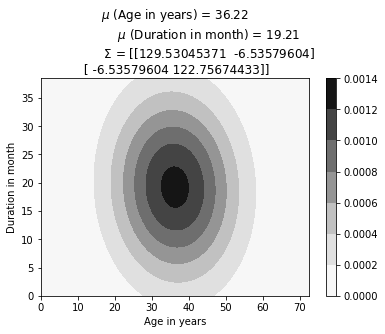

In [10]:
max_avg = routine_gradient_descent(
    df=df_normal, 
    columns=numerical_attr, 
    iterations=20, 
    plot_scale=2
)
                
#plot_gaussian(mu=muv_good, sigma2=cov_good)

### Dataframe = numerical (24 numerical attributes / 24*24 combinations)

In [79]:
#max_avg = routine_gradient_descent(df_numerical, df_numerical.columns, 10)

In [25]:
'''
Probleme:
(1) Ich weiß nicht ob ich 
    (a) irgendwo einen Fehler habe oder 
    (b) schlechte Parameter habe oder 
    (c) die Daten bei nur 2 Parametern mit MLE nur so viel Accuracy geben
    
(2) Plot ist schwierig
    --> 2 Ansätze
    (a) Contour Plot - Plotte flach aber mit Farbkreisen 
    (b) Plotte 3D 
--> brauch ich doch zwei Sigma Werte?

(3) Risk Analysis - woher die Formel?

'''

'\nProbleme:\n(1) Ich weiß nicht ob ich \n    (a) irgendwo einen Fehler habe oder \n    (b) schlechte Parameter habe oder \n    (c) die Daten bei nur 2 Parametern mit MLE nur so viel Accuracy geben\n    \n(2) Plot ist schwierig\n    --> 2 Ansätze\n    (a) Contour Plot - Plotte flach aber mit Farbkreisen \n    (b) Plotte 3D \n--> brauch ich doch zwei Sigma Werte?\n\n(3) Risk Analysis - woher die Formel?\n\n'

In [73]:
at1 = COLS[Cols.AgeInYears]
at2 = COLS[Cols.NumberOfExistingCreditsAtThisBank]

df_a = pd.DataFrame({
            at1 : df_normal[at1],
            at2 : df_normal[at2],
#            COLS[Cols.ClassOutcome] : df_normal[COLS[Cols.ClassOutcome]]
        })
c= df_a.cov().to_numpy()
c

array([[129.40128529,   0.98075876],
       [  0.98075876,   0.33368468]])